In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

import json
from angle_calculation import calculate_six_arm_angles
from utilities import (convert_to_shoulder_coord,
    convert_to_wrist_coord,
    flatten_two_camera_input)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [3]:
measure_noise_csv_files = [
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:36/landmarks_all_2024-09-26-17:36.csv",
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:39/landmarks_all_2024-09-26-17:39.csv",
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:40/landmarks_all_2024-09-26-17:40.csv",
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:42/landmarks_all_2024-09-26-17:42.csv",
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:43/landmarks_all_2024-09-26-17:43.csv",
    "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:44/landmarks_all_2024-09-26-17:44.csv"
]

Get the noise when the left arm does not move

In [4]:
angles_error = []

for csv_file in measure_noise_csv_files:
    data = pd.read_csv(csv_file)
    total_rows = len(data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values
    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_shoulder_coord(
        gt_data[0],
        arm_hand_fused_names)

    angles_at_start_pos, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
        xyz_origin,
        arm_hand_fused_names)
    angles_at_start_pos = np.array(angles_at_start_pos)

    for i in range(1, gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        angles_at_current_frame, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
            xyz_origin,
            arm_hand_fused_names)
        angles_at_current_frame = np.array(angles_at_current_frame)
        angles_error.append(np.abs(angles_at_current_frame - angles_at_start_pos))

angles_error = np.array(angles_error)
#lmks_error = lmks_error.reshape(-1, 3, 48)
#lmks_error = np.transpose(lmks_error, (0, 2, 1))

In [5]:
angles_error.shape

(475, 6)

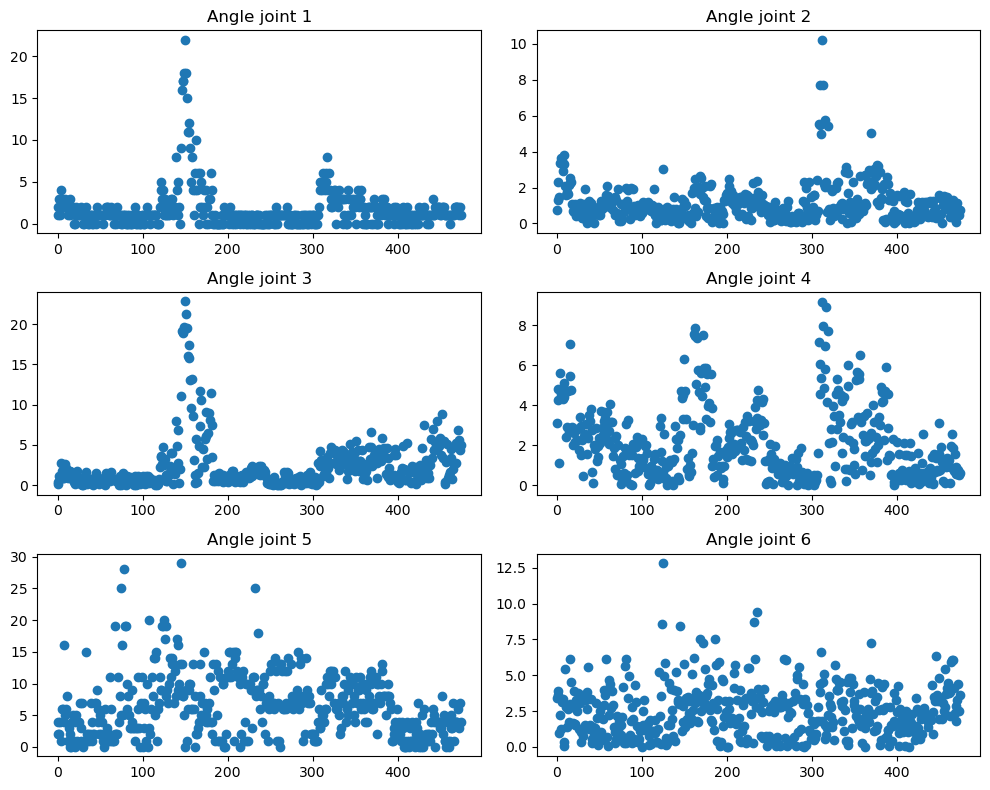

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()

for i in range(angles_error.shape[1]):
    ax = axes[i]
    angle_err = angles_error[:, i]
    ax.scatter(x=range(angle_err.shape[0]), y=angle_err)
    title = "Angle joint {}".format(i + 1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [7]:
angles_measure_noises = np.var(angles_error, axis=0)

In [8]:
def get_angle_initial_expectation_and_cov(home_position_file):
    home_position_data = pd.read_csv(home_position_csv_file)
    total_rows = len(home_position_data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = home_position_data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values

    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    angles = []
    for i in range(gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        angles_at_current_frame, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
            xyz_origin,
            arm_hand_fused_names)
        angles_at_current_frame = np.array(angles_at_current_frame)
        angles.append(angles_at_current_frame)

    angles = np.array(angles)
    home_init_expectation = np.mean(angles, axis=0)
    home_init_cov = np.var(angles, axis=0)

    return home_init_expectation, home_init_cov

In [9]:
home_position_csv_file = "/home/giakhang/dev/pose_sandbox/data/2024-09-26/2024-09-26-17:36/landmarks_all_2024-09-26-17:36.csv"
home_init_expectation, home_init_cov = get_angle_initial_expectation_and_cov(home_position_csv_file)

For safe situation, set joint 3 expectation = -5

In [10]:
home_init_expectation[2] = -5

In [11]:
angles_stats_dict = dict()

for i in range(6):
    stats = dict()

    angle_noise_var = angles_measure_noises[i]
    init_exp = home_init_expectation[i]
    init_cov = home_init_cov[i]

    stats["measure_noise"] = angle_noise_var
    stats["filter_state_estimate"] = init_exp
    stats["cov"] = init_cov

    angles_stats_dict["joint{}".format(i + 1)] = stats

In [12]:
des_json_file = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/angles_stats.json"
with open(des_json_file, 'w') as file:
    json.dump(angles_stats_dict, file)